In [1]:
import torch
import urllib
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Adversarial Attack

An adversarial attack is a method in which you attempt to deceive a neural network by misclassifying an example with the smallest change to the input. An input that can deceive the network is known as an adversarial example. Adversarial examples are counterfactual examples aimed at deceiving the model, not interpreting it.

Adversarial attacks are a critical aspect of machine learning. In certain areas of research, misclassification is not tolerable. For instance, if someone were to place a small piece of tape on a stop sign, your self-driving car might misidentify it and drive through the intersection without issue

Various techniques have been developed to create adversarial examples. The majority of these approaches aim to minimize the distance between the adversarial example and the target instance, while simultaneously altering the prediction towards the intended (adversarial) outcome. Certain techniques require access to the model gradients, which limits their utility to gradient-based models like neural networks. Conversely, other methods solely necessitate access to the prediction function, rendering them model-agnostic.

In [3]:
# Loading model
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
_ = model.eval()

Using cache found in C:\Users\ftkni/.cache\torch\hub\pytorch_vision_v0.10.0


In [4]:
# preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),  # resize
    transforms.CenterCrop(224),  # crop the center
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize channels (RGB pixel values)
])

# for a single instance
preprocess_instance = lambda x: preprocess(x).unsqueeze(0)  # we have to reshape it as a batch

In [5]:
# download an example image
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")

def download(url, filename):
    try: 
        urllib.URLopener().retrieve(url, filename)
    except: 
        urllib.request.urlretrieve(url, filename)
        
download(url, filename)

In [6]:
input_image = Image.open(filename)
input_batch = preprocess_instance(input_image)

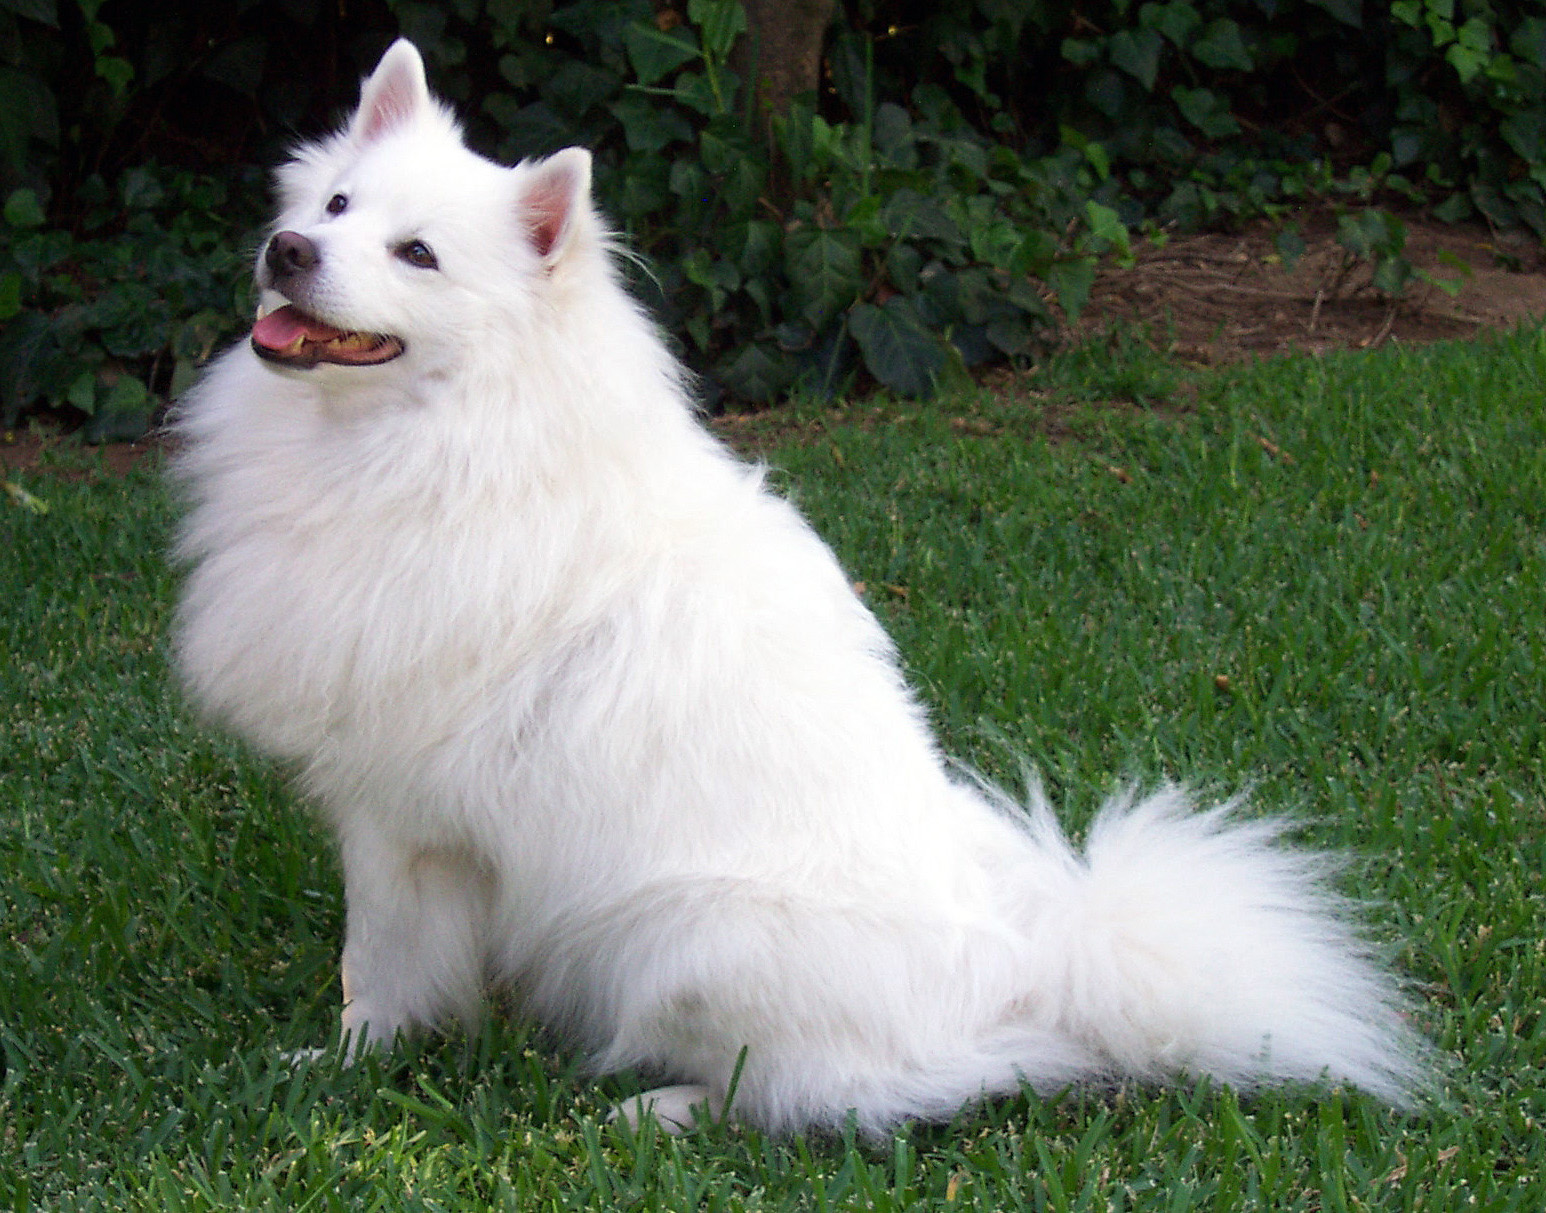

In [7]:
display(input_image)

In [8]:
# downloading labels

download("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", "imagenet_classes.txt")
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [9]:
with torch.no_grad():
    output = model(input_batch)

probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)

for i, id_ in enumerate(top5_catid):
    print(f"{categories[id_]} with probablity of {top5_prob[i]}")

Samoyed with probablity of 0.9998961687088013
white wolf with probablity of 8.390838047489524e-05
Arctic fox with probablity of 1.1692862244672142e-05
Eskimo dog with probablity of 2.6133207029488403e-06
Great Pyrenees with probablity of 2.0891895928798476e-06


In [11]:
top5_catid

tensor([258, 270, 279, 248, 257])

# Szegedy et. al.

## Algorithm

In [13]:
import torch.nn as nn

loss = nn.CrossEntropyLoss()

In [14]:
import torch.optim as optim
import tqdm 

r = torch.rand(1, 224, 224)
r.requires_grad_()

optimizer_adv = optim.Adam([r], lr=0.001)

for i in tqdm.trange(3000):
    X = torch.clamp(input_batch + r, 0, 1)  
    Y = torch.tensor([270])

    outputs = model(X)
    _, predicted = torch.max(outputs.data, 1)

    loss_adv = r.abs().sum() + loss(outputs, Y)

    optimizer_adv.zero_grad()
    loss_adv.backward(retain_graph=True)
    optimizer_adv.step()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [10:52<00:00,  4.60it/s]


In [17]:
categories[predicted.item()]

'Samoyed'

In [18]:
torch.nn.functional.softmax(outputs[0], dim=0)[predicted.item()].item()

0.9750109314918518

## Exmaples

In [38]:
import torch.nn as nn
import torch.optim as optim
import tqdm 
import matplotlib as mpl


inverse_normalization = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)


def szegedy(image, model, iterations, adversarial_label, lr=0.001, c=1.0, device="cpu"):
    model = model.to(device)
    loss = nn.CrossEntropyLoss()
    img = preprocess_instance(image).to(device)
    
    # eval model on sample
    with torch.no_grad():
        output = model(img)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i, id_ in enumerate(top5_catid):
        print(f"[Original Input] {categories[id_]} ({id_}) with probablity of {top5_prob[i]}")

    # adversarial offset
    r = torch.rand(3, 224, 224).to(device)
    r.requires_grad_()

    optimizer_adv = optim.Adam([r], lr=lr)

    for i in tqdm.trange(iterations):
        X = torch.clamp(input_batch + r, 0, 1)  
        Y = torch.tensor([adversarial_label]).to(device)

        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)

        loss_adv = loss(outputs, Y) + c * r.abs().sum()

        optimizer_adv.zero_grad()
        loss_adv.backward(retain_graph=True)
        optimizer_adv.step()
        
    probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i, id_ in enumerate(top5_catid):
        print(f"[Adversarial Input] {categories[id_]} ({id_}) with probablity of {top5_prob[i]}")
        
    with torch.no_grad():
        img = inverse_normalization(img[0]).cpu().detach().numpy().transpose(1, 2, 0)
        offset = r.cpu().detach().numpy().transpose(1, 2, 0)
        changed = img + offset
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title("Image")
    plt.subplot(1, 3, 2)
    plt.imshow(offset, cmap=mpl.colormaps['viridis'])
    plt.xticks([])
    plt.yticks([])
    plt.title("Noise")
    plt.subplot(1, 3, 3)
    plt.imshow(changed)
    plt.xticks([])
    plt.yticks([])
    plt.title("Adverserial Example")
    
    return img, offset, changed

In [22]:
files = (
    ("https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01440764_tench.JPEG", "tench.jpg"),
    ("https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01514668_cock.JPEG", "cock.jpg"),
    ("https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01807496_partridge.JPEG", "partridge.jpg"),
    ("https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01784675_centipede.JPEG", "centipede.jpg")
)

files = [(download(url, file), file)[1] for url, file in files]
images = [(file, Image.open(file)) for file in files]

[Original Input] tench (0) with probablity of 0.9718676805496216
[Original Input] barracouta (389) with probablity of 0.024440975859761238
[Original Input] coho (391) with probablity of 0.003606281941756606
[Original Input] goldfish (1) with probablity of 1.8097847714670934e-05
[Original Input] gar (395) with probablity of 1.6794550901977345e-05


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [11:47<00:00,  4.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Adversarial Input] Samoyed (258) with probablity of 0.9637848734855652
[Adversarial Input] white wolf (270) with probablity of 0.0285378135740757
[Adversarial Input] West Highland white terrier (203) with probablity of 0.002796869957819581
[Adversarial Input] Great Pyrenees (257) with probablity of 0.0023494239430874586
[Adversarial Input] kuvasz (222) with probablity of 0.0015774626517668366


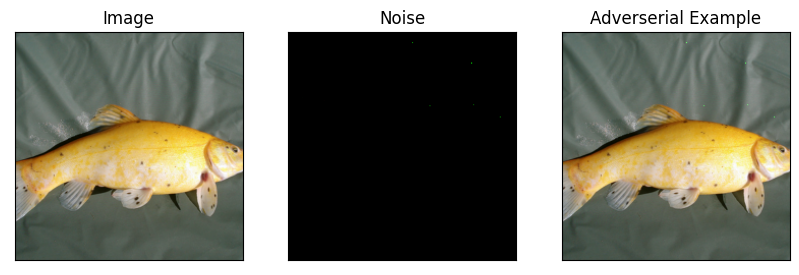

In [39]:
_, _, _ = szegedy(images[0][1], model, 3000, lr=0.001, c=0.5, adversarial_label=389)

(224, 224, 3)